# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# import dependencies 
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
import time
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

In [6]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    """Execute training of Deep Deterministic Policy - DDPQ agent.

    Params
    ======
        n_episodes (int): number of episodes
        max_t (int):      maxiumum number of time steps per episode
        print_every (int): print every interval
        
    """ 
    scores_overall = []
    scores_deque = deque(maxlen=print_every)
    agents = []
    running_avg = [] # get the mean average score
    
    # initiatise
    for i in range(num_agents):
        agents.append(Agent(state_size, action_size, num_agents = 1, random_seed=0))
    begin = time.time()
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]             # reset the environment
        states = env_info.vector_observations                         # get the current states

        # reset agents after each episode
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents)
        start = time.time()
        for t in range(max_t):
            agent_actions = []
            for agent in agents:                                      # choose an action for the agents
                agent_actions.append(agent.act(states, timestep = t))

            actions = np.hstack((agent_actions[0], agent_actions[1])) # combine actions from agent 1 and 2
            env_info = env.step(actions)[brain_name]                  # send the action to the environment
            next_states = env_info.vector_observations                # get the next state
            rewards = env_info.rewards                                # get the reward
            dones = env_info.local_done                               # see if episode has finished
            
            num_agent = 0
            for agent in agents:                                      # next learning step for agents
                agent.step(states, actions, rewards[num_agent], 
                           next_states, dones, t, num_agent)          # take step with agent (including learning)
                num_agent += 1
                
            scores += rewards                                         # update the score
            states = next_states                                      # roll over the state to next time step
            if np.any(dones):                                         # exit loop if episode finished
                break
                
        score = np.max(scores)                                        # take the max score of the agents
        scores_deque.append(score)                                    # save most recent score
        scores_overall.append(score)                                  # save most recent score
        running_avg.append(np.mean(scores_deque))                     # save most recent average score
        end = time.time()
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        print('\rEpisode {}\tAverage Score: {:.4f}\tTime Cost per epi: {:.4f}'.format(i_episode,
                                                                                      np.mean(scores_deque), 
                                                                                      end-start), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            agent_num = 0
            for agent in agents:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_' + str(agent_num) + '.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_' + str(agent_num) + '.pth')
                agent_num += 1
        
        if np.mean(scores_deque)>=0.5: # 50% win rate
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            agent_num = 0
            for agent in agents:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_' + str(agent_num) + '.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_' + str(agent_num)+ '.pth')
                agent_num += 1
            break
    final_end = time.time()
    print("Total time taken: {:.2f}".format(final_end-begin))
    return scores_overall, running_avg

Episode 100	Average Score: 0.0058	Time Cost per epi: 0.2644
Episode 200	Average Score: 0.0202	Time Cost per epi: 0.5353
Episode 300	Average Score: 0.0543	Time Cost per epi: 0.2686
Episode 400	Average Score: 0.0657	Time Cost per epi: 0.5409
Episode 500	Average Score: 0.0746	Time Cost per epi: 0.2727
Episode 600	Average Score: 0.0873	Time Cost per epi: 0.5458
Episode 700	Average Score: 0.1091	Time Cost per epi: 0.2684
Episode 800	Average Score: 0.1450	Time Cost per epi: 0.4757
Episode 900	Average Score: 0.1627	Time Cost per epi: 0.2767
Episode 1000	Average Score: 0.2735	Time Cost per epi: 0.4698
Episode 1100	Average Score: 0.1474	Time Cost per epi: 1.6798
Episode 1200	Average Score: 0.1948	Time Cost per epi: 0.4766
Episode 1300	Average Score: 0.4034	Time Cost per epi: 0.47793
Episode 1346	Average Score: 0.5064	Time Cost per epi: 15.0328
Environment solved in 1346 episodes!	Average Score: 0.5064
Total time taken: 1326.05


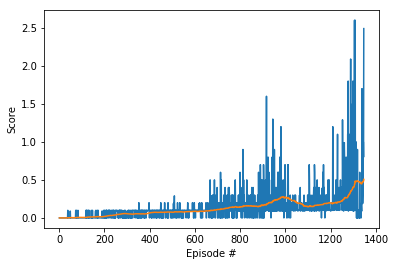

In [7]:

scores, running_avg = ddpg(n_episodes = 3000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(running_avg)+1), running_avg)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()